# First part: Using compressor of statnetencoder, so not sure if correct

## Dependencies & Hyperparameters

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE
import numpy as np
sys.path.append('/home/gridsan/ckoevesdi/.local/lib/python3.9/site-packages/')
from pytorch_metric_learning import losses
import os
sys.path.append('/home/gridsan/ckoevesdi/PooledStatisticsMetamers/poolstatmetamer/')
import utils.statnetencoder as sne
import importlib
import imp
import torch.nn.functional as F

#!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py

#sys.path.append(r'C:\Users\chris\Documents\MIT\Statistics_analysis_code\PyTorchSteerablePyramid')
sys.path.append('/home/gridsan/ckoevesdi/PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch

torch.manual_seed(16)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
#hyperparams
num_epochs = 100
batch_size = 1
crop_size = 128 
num_stats = 50 
optimizer_type='adam'
#optimizer_type='sgd'
learning_rate = 0.001
num_crops = 5 #changed this to four

multistat_penalty = 0
sparsity_penalty = 0 #0.01
entropic_penalty = 0

## Create Dataset and define DataLoader

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class KTHImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Filtering only directories for classes
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)

            # Scanning for image files directly in the class folder
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)

                if os.path.isfile(img_path):  # Checking if it's a file
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Specify transformations
loading_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((200, 200)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.FiveCrop(size=crop_size), 
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # Changed PILToTensor to ToTensor as it's more standard
    transforms.ConvertImageDtype(torch.float32)
])

# Initialize dataset and dataloader
sys.path.append('/home/gridsan/ckoevesdi/data_KTH_HB/')

root_dir = '/home/gridsan/ckoevesdi/data_KTH_HB/'
dataset = KTHImageDataset(root_dir=root_dir, transform=loading_transforms)
kth_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [5]:
import utils.brucenet as bn
brucy = bn.BruceNet(pooling_region_size=1e20, pyramid_params=False, dummy_img = torch.zeros(20,
                                     1,
                                     128,
                                     128)).to(device)


Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
all_statistics = []

for j, (texture_batch, labels) in enumerate(kth_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    for i in range(texture_batch.shape[0]):  # Loop over batch
        mini_batch = texture_batch[i]  # This should have a shape of [5, 1, 128, 128]
        mini_batch = mini_batch.to(device)

        # Now you can call brucy, which expects a tensor with shape x,1,128,128 where x > 1
        statistics = brucy(mini_batch)  # This should output a tensor of shape [5, 150]
        
        # You can now store these statistics, along with the label and original image index
        all_statistics.append({
            'statistics': statistics.cpu().numpy(),
            #'label': labels[i].item(),
            'original_image_index': j * texture_batch.shape[0] + i
        })



In [7]:
statistics_array = np.array([item['statistics'] for item in all_statistics])
print(statistics_array.shape)
num_stats = statistics_array.shape[2]
print(num_stats)

(4752, 5, 152)
152


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
#print(statistics_array.shape)
labels_array = np.array([item['original_image_index'] for item in all_statistics])
# Standardize
scaler = StandardScaler()

reshaped_array = statistics_array.reshape(-1,num_stats)
#print(reshaped_array.shape)
scaled_array = scaler.fit_transform(reshaped_array)

statistics_array = scaled_array.reshape(len(dataset), 5, num_stats)
statistics_tensor = torch.tensor(statistics_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)


In [9]:
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'edge_mean 1 0', 'edge_variance 1 0', 'edge_correlation (1, 2) 0', 'edge_stop 1 0', 'edge_mean 1 1', 'edge_variance 1 1', 'edge_correlation (1, 2) 1', 'edge_stop 1 1', 'edge_mean 1 2', 'edge_variance 1 2', 'edge_correlation (1, 2) 2', 'edge_stop 1 2', 'edge_mean 1 3', 'edge_variance 1 3', 'edge_correlation (1, 2) 3', 'edge_stop 1 3', 'edge_correlation 1 (0, 1)', 'edge_correlation 1 (0, 2)', 'edge_correlation 1 (0, 3)', 'edge_correlation 1 (1, 2)', 'edge_correlation 1 (1, 3)', 'edge_correlation 1 (2, 3)', 'edge_mean 2 0', 'edge_variance 2 0', 'edge_correlation (2, 3) 0', 'edge_stop 2 0', 'edge_mean 2 1', 'edge_variance 2 1', 'edge_correlation (2, 3) 1', 'edge_stop 2 1', 'edge_mean 2 2', 'edge_variance 2 2', 'edge_correlation (2, 3) 2', 'edge_stop 2 2', 'edge_mean 2 3', 'edge_variance 2 3', 'edge_correlation (2, 3) 3', 'edge_stop 2 3', 'edge_correlation 2 (0, 1)', 'edge_correlation 2 (0, 2)', 'edge_correlation 2 (0, 3)', 'edge_correlation 2 (1, 2)', 'edge_correlation 2 (1, 3)', 'edge_correlation 2 (2, 3)', 'edge_mean 3 0', 'edge_variance 3 0', 'edge_correlation (3, 4) 0', 'edge_stop 3 0', 'edge_mean 3 1', 'edge_variance 3 1', 'edge_correlation (3, 4) 1', 'edge_stop 3 1', 'edge_mean 3 2', 'edge_variance 3 2', 'edge_correlation (3, 4) 2', 'edge_stop 3 2', 'edge_mean 3 3', 'edge_variance 3 3', 'edge_correlation (3, 4) 3', 'edge_stop 3 3', 'edge_correlation 3 (0, 1)', 'edge_correlation 3 (0, 2)', 'edge_correlation 3 (0, 3)', 'edge_correlation 3 (1, 2)', 'edge_correlation 3 (1, 3)', 'edge_correlation 3 (2, 3)', 'edge_mean 4 0', 'edge_variance 4 0', 'edge_stop 4 0', 'edge_mean 4 1', 'edge_variance 4 1', 'edge_stop 4 1', 'edge_mean 4 2', 'edge_variance 4 2', 'edge_stop 4 2', 'edge_mean 4 3', 'edge_variance 4 3', 'edge_stop 4 3', 'edge_correlation 4 (0, 1)', 'edge_correlation 4 (0, 2)', 'edge_correlation 4 (0, 3)', 'edge_correlation 4 (1, 2)', 'edge_correlation 4 (1, 3)', 'edge_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

In [10]:
from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
statistics_dataset = StatisticsDataset(statistics_tensor, labels_tensor)


In [11]:
# Create the DataLoader object first
batches = 100
statistics_dataloader = DataLoader(statistics_dataset, batch_size=batches, shuffle=True)

# Loop through a couple of batches
if(False):
    for i, (stats_batch, label_batch) in enumerate(statistics_dataloader):
        if i > 1:  # We only want to look at a couple of batches
            break

        print(f"Batch {i + 1}")

        # Dimensionality Check
        print("Statistics Batch Shape:", stats_batch.shape)  
        print("Label Batch Shape:", label_batch.shape)

        # Data Type Check
        print("Statistics Data Type:", stats_batch.dtype)
        print("Label Data Type:", label_batch.dtype)

        # Label Consistency (and value preview)
        print("Statistics:", stats_batch)
        print("Labels:", label_batch)


In [12]:
importlib.reload(sne)
statnet_model = sne.StatNetEncoder(img_size=(crop_size,crop_size),
                                   batch_size=batch_size,
                                   num_stats=num_stats,
                                   device=device)
stat_labels = statnet_model.getsstatlabels(device)
#optimizer
if(optimizer_type=='sgd'):
    optimizer = torch.optim.SGD(statnet_model.parameters(), lr=learning_rate)#, momentum=learning_momentum)
elif(optimizer_type=='adam'):
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adagrad'):
    optimizer = torch.optim.Adagrad(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adadelta'):
    optimizer = torch.optim.Adadelta(statnet_model.parameters(), lr=learning_rate)
else:
    print('No Optimizer Specified! Adam is default!')
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


In [13]:
print('Total Stats:',len(stat_labels))
summation=0
for stat in ['edge_mean','edge_variance','edge_stop','edge_correlation','phase_correlation','mean','variance','bandpass_variance','skew','kurtosis']:
    num_this_stat = len([s for s in stat_labels if s.weight_category==stat])
    print(f'{stat} Stat:',num_this_stat)
    summation += num_this_stat
print('Stats Sum to:',summation)
#[s for s in stat_labels] #print all stats with details

Total Stats: 152
edge_mean Stat: 16
edge_variance Stat: 16
edge_stop Stat: 16
edge_correlation Stat: 36
phase_correlation Stat: 48
mean Stat: 1
variance Stat: 6
bandpass_variance Stat: 1
skew Stat: 6
kurtosis Stat: 6
Stats Sum to: 152


## Try naive approach: Previous architecture on this problem

In [16]:
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_total_epochs = 0
#[s for s in stat_labels] #print all stats with details
statnet_model.train() # Set model to training mode
optimizer.zero_grad()
statnet_model.zero_grad()

Starting Training:
*****************************************Finished Epoch 0. Loss at 8.061369895935059.


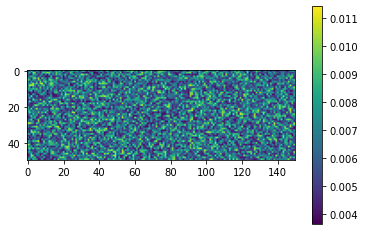

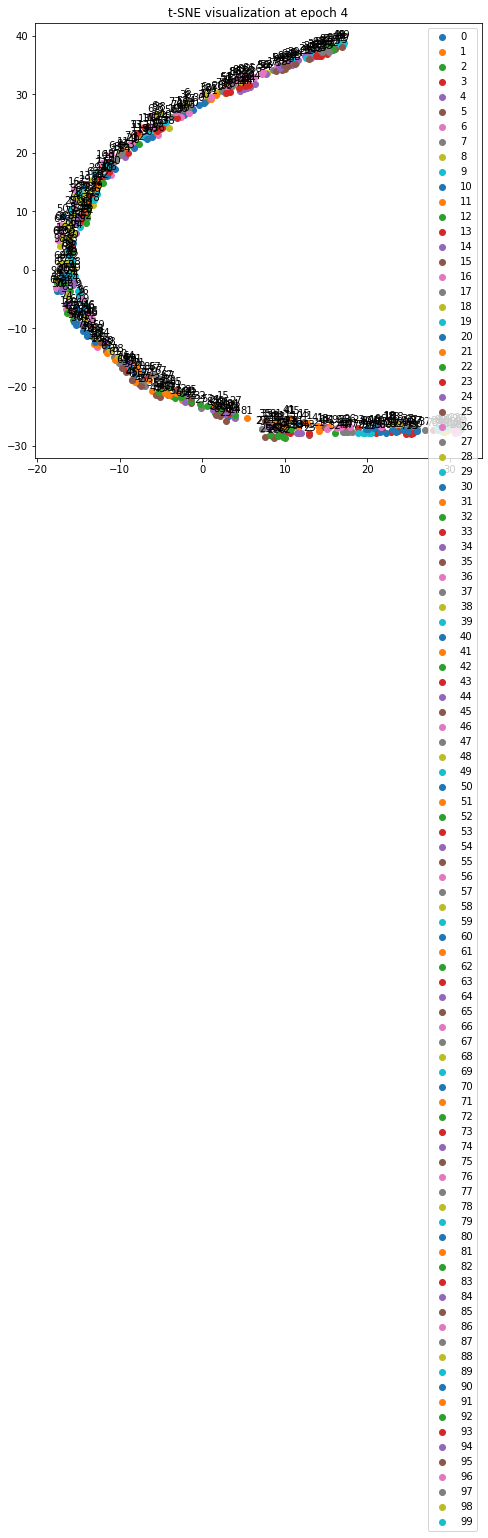

*****************************************Finished Epoch 1. Loss at 8.007201194763184.
*****************************************Finished Epoch 2. Loss at 8.06055736541748.
*****************************************Finished Epoch 3. Loss at 7.962214946746826.
*****************************************Finished Epoch 4. Loss at 7.925825595855713.
*****************************************Finished Epoch 5. Loss at 7.96068000793457.
*****************************************Finished Epoch 6. Loss at 7.921150207519531.
*****************************************Finished Epoch 7. Loss at 7.887019157409668.
*****************************************Finished Epoch 8. Loss at 7.879494667053223.
*****************************************Finished Epoch 9. Loss at 7.867185592651367.
*****************************************Finished Epoch 10. Loss at 7.867136001586914.


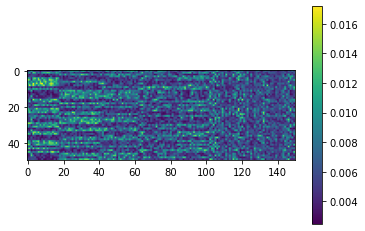

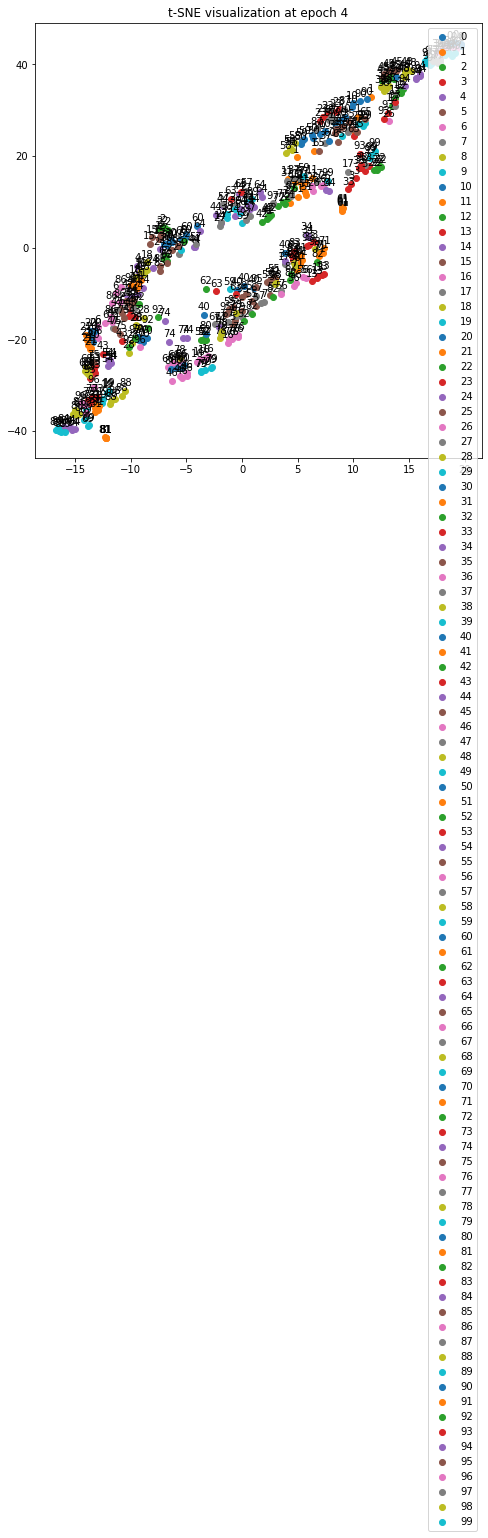

*****************************************Finished Epoch 11. Loss at 7.781665802001953.
*****************************************Finished Epoch 12. Loss at 7.835372447967529.
*****************************************Finished Epoch 13. Loss at 7.831982612609863.
*****************************************Finished Epoch 14. Loss at 7.763854026794434.
*****************************************Finished Epoch 15. Loss at 7.762634754180908.
*****************************************Finished Epoch 16. Loss at 7.763551712036133.
*****************************************Finished Epoch 17. Loss at 7.71212911605835.
*****************************************Finished Epoch 18. Loss at 7.773763656616211.
*****************************************Finished Epoch 19. Loss at 7.729867458343506.
*****************************************Finished Epoch 20. Loss at 7.7684454917907715.


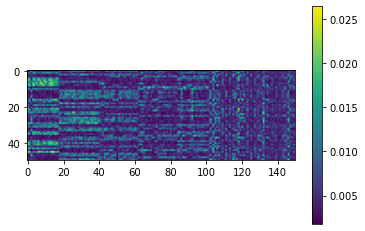

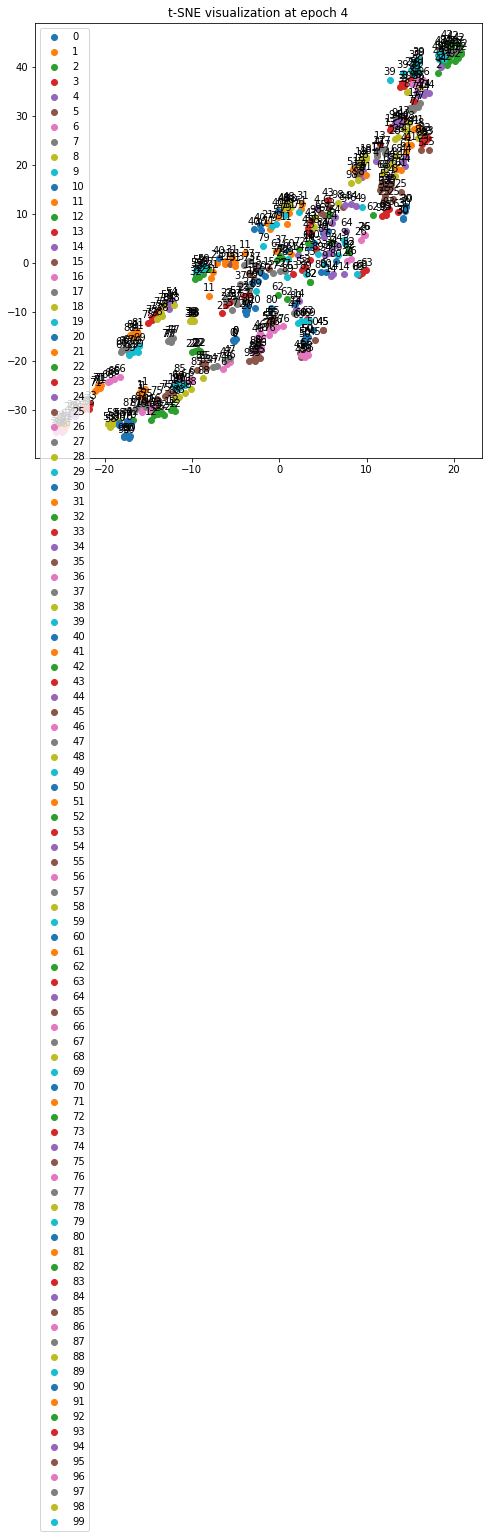

*****************************************Finished Epoch 21. Loss at 7.7481536865234375.
*****************************************Finished Epoch 22. Loss at 7.707514762878418.
*****************************************Finished Epoch 23. Loss at 7.7242326736450195.
*****************************************Finished Epoch 24. Loss at 7.71350622177124.
*****************************************Finished Epoch 25. Loss at 7.669593811035156.
*****************************************Finished Epoch 26. Loss at 7.745759010314941.
*****************************************Finished Epoch 27. Loss at 7.725668907165527.
*****************************************Finished Epoch 28. Loss at 7.6590189933776855.
*****************************************Finished Epoch 29. Loss at 7.6802239418029785.
*****************************************Finished Epoch 30. Loss at 7.659418106079102.


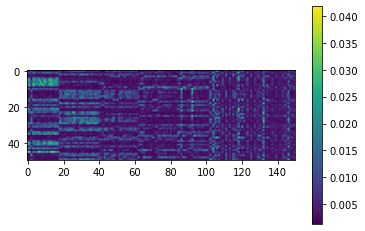

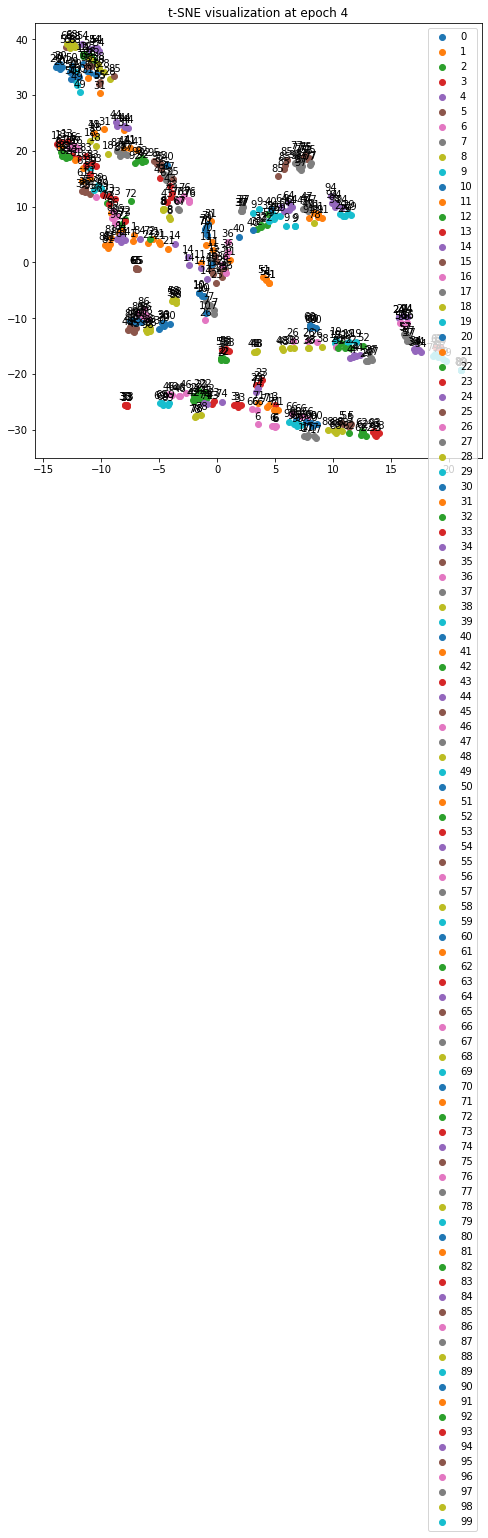

*****************************************Finished Epoch 31. Loss at 7.7219624519348145.
*****************************************Finished Epoch 32. Loss at 7.686778545379639.
*****************************************Finished Epoch 33. Loss at 7.708937644958496.
*****************************************Finished Epoch 34. Loss at 7.700636863708496.
*****************************************Finished Epoch 35. Loss at 7.687276363372803.
*****************************************Finished Epoch 36. Loss at 7.614099502563477.
*****************************************Finished Epoch 37. Loss at 7.6346354484558105.
*****************************************Finished Epoch 38. Loss at 7.683250427246094.
*****************************************Finished Epoch 39. Loss at 7.680548191070557.
*****************************************Finished Epoch 40. Loss at 7.708926200866699.


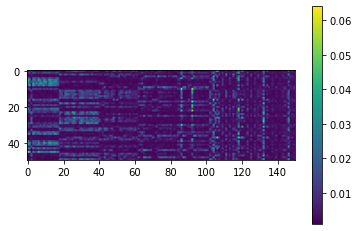

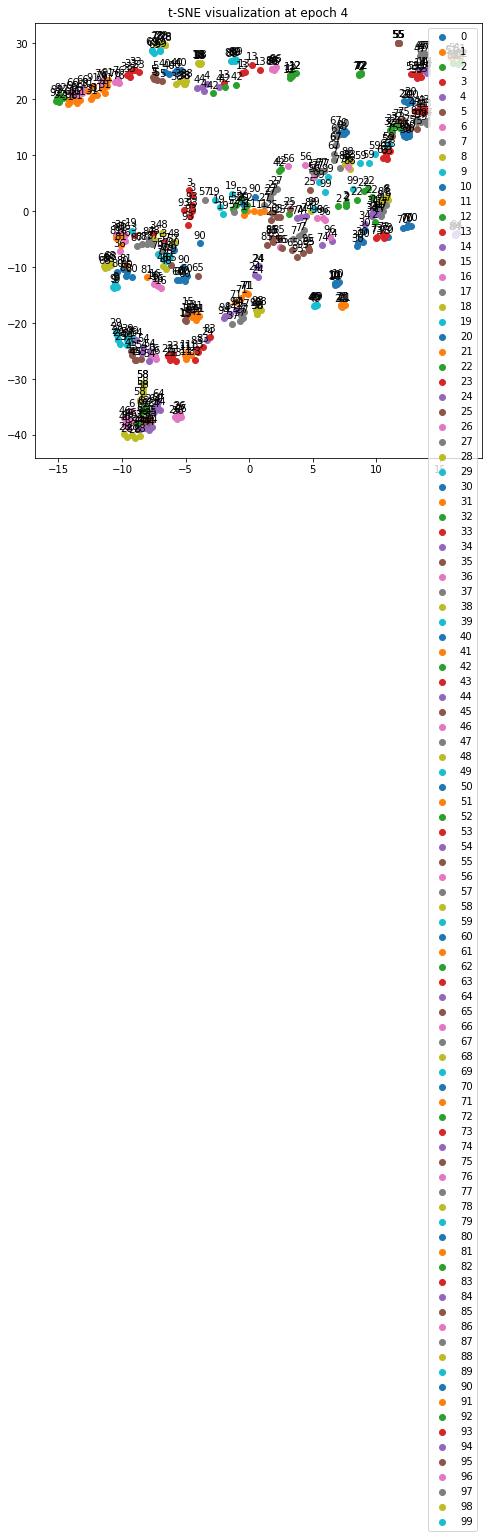

*****************************************Finished Epoch 41. Loss at 7.668194770812988.
*****************************************Finished Epoch 42. Loss at 7.667329788208008.
*****************************************Finished Epoch 43. Loss at 7.655643939971924.
*****************************************Finished Epoch 44. Loss at 7.616934776306152.
*****************************************Finished Epoch 45. Loss at 7.620558738708496.
*****************************************Finished Epoch 46. Loss at 7.715210914611816.
*****************************************Finished Epoch 47. Loss at 7.619722843170166.
*****************************************Finished Epoch 48. Loss at 7.654423236846924.
*****************************************Finished Epoch 49. Loss at 7.62447452545166.
*****************************************Finished Epoch 50. Loss at 7.647867679595947.


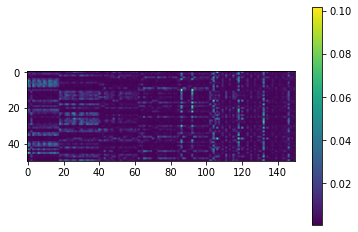

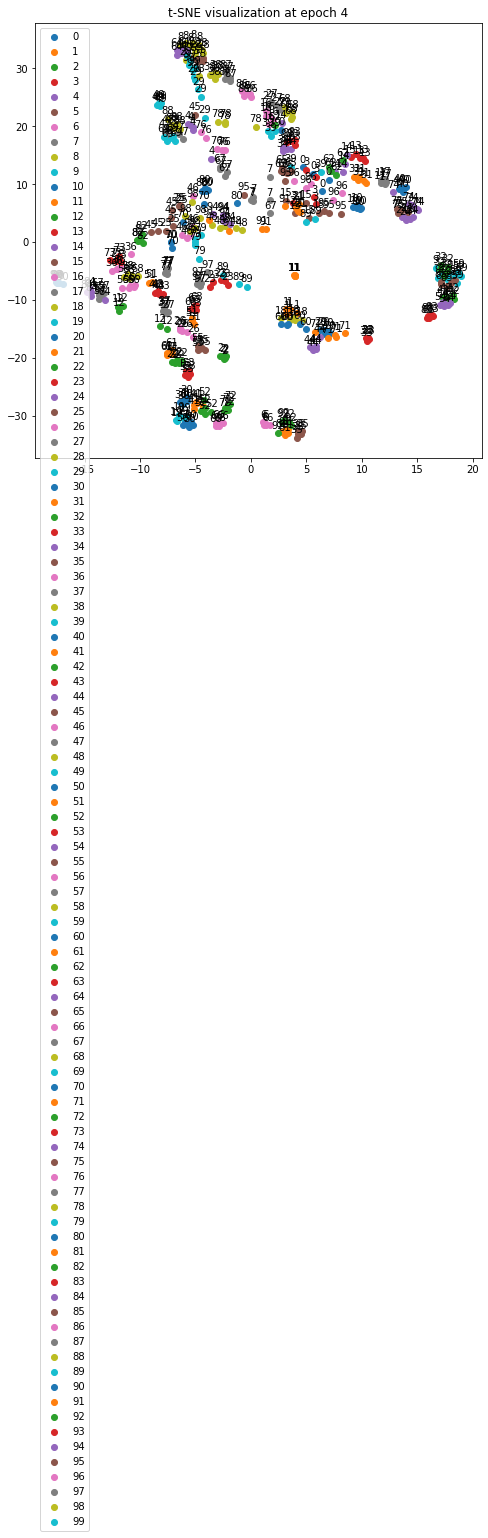

*****************************************Finished Epoch 51. Loss at 7.6335768699646.
*****************************************Finished Epoch 52. Loss at 7.589727401733398.
*****************************************Finished Epoch 53. Loss at 7.6064839363098145.
*****************************************Finished Epoch 54. Loss at 7.608250141143799.
*****************************************Finished Epoch 55. Loss at 7.623394966125488.
*****************************************Finished Epoch 56. Loss at 7.6124725341796875.
*****************************************Finished Epoch 57. Loss at 7.597659111022949.
*****************************************Finished Epoch 58. Loss at 7.573811054229736.
*****************************************Finished Epoch 59. Loss at 7.607254505157471.
*****************************************Finished Epoch 60. Loss at 7.595844268798828.


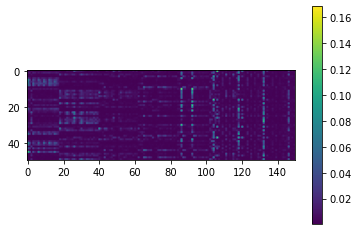

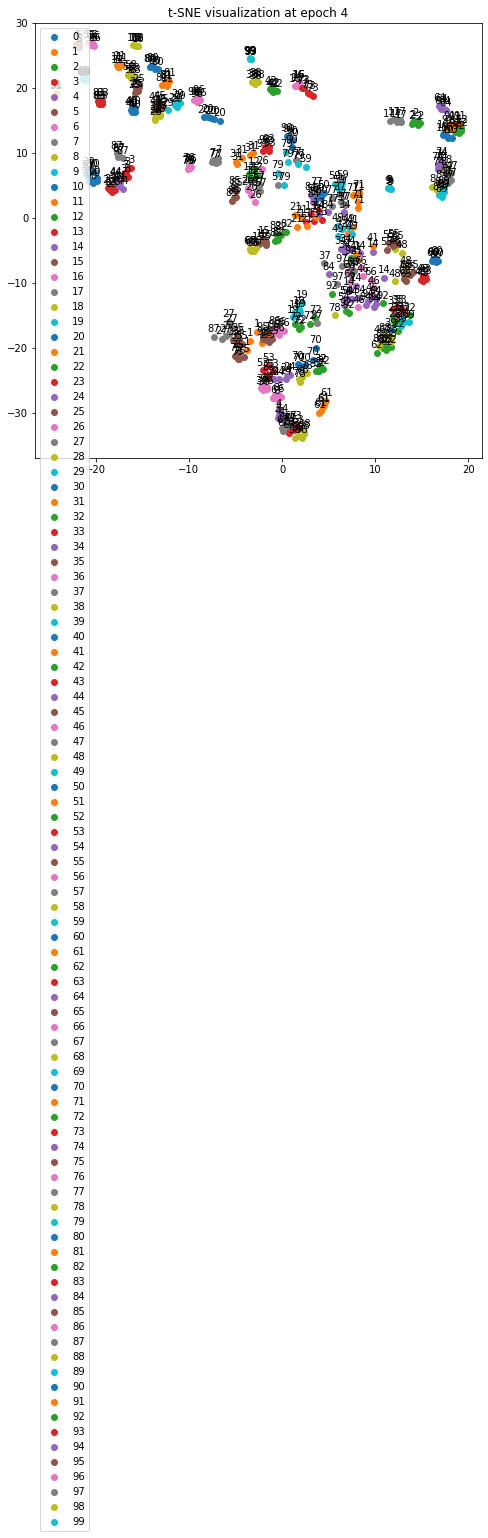

*****************************************Finished Epoch 61. Loss at 7.594766616821289.
*****************************************Finished Epoch 62. Loss at 7.579733848571777.
*****************************************Finished Epoch 63. Loss at 7.595002174377441.
*****************************************Finished Epoch 64. Loss at 7.596705436706543.
*****************************************Finished Epoch 65. Loss at 7.558117866516113.
*****************************************Finished Epoch 66. Loss at 7.592962741851807.
*****************************************Finished Epoch 67. Loss at 7.575928211212158.
*****************************************Finished Epoch 68. Loss at 7.579235553741455.
*****************************************Finished Epoch 69. Loss at 7.6256303787231445.
*****************************************Finished Epoch 70. Loss at 7.582403182983398.


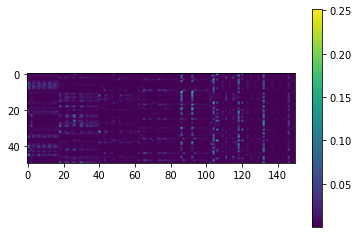

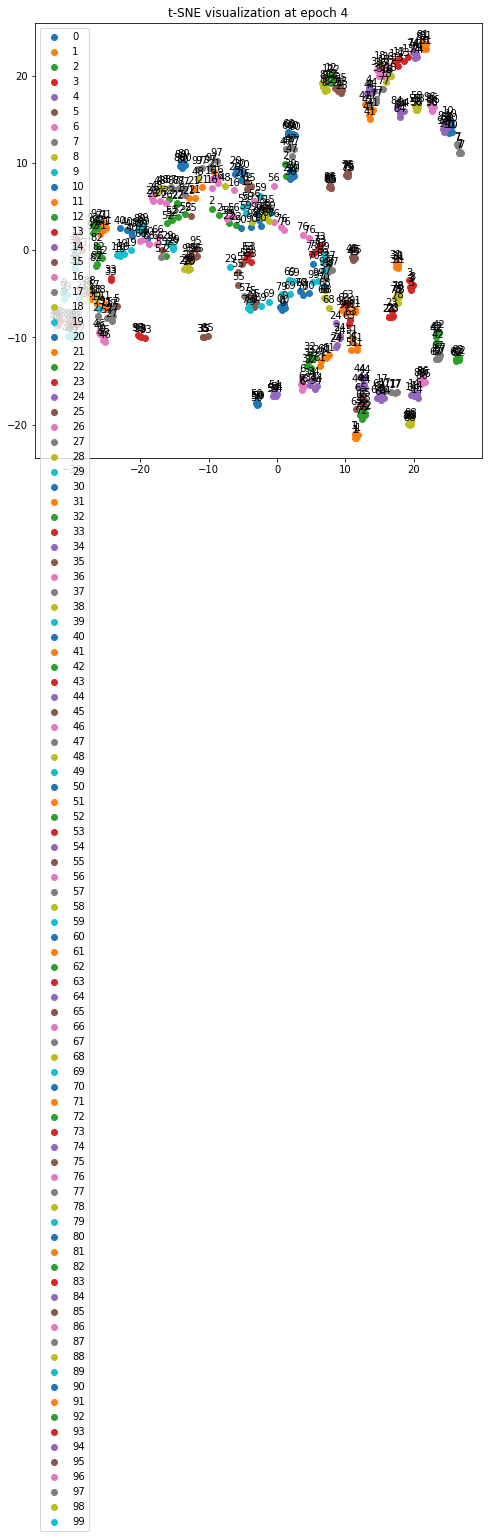

*****************************************Finished Epoch 71. Loss at 7.659931182861328.
*****************************************Finished Epoch 72. Loss at 7.561856269836426.
*****************************************Finished Epoch 73. Loss at 7.567287445068359.
*****************************************Finished Epoch 74. Loss at 7.5687150955200195.
*****************************************Finished Epoch 75. Loss at 7.573179244995117.
*****************************************Finished Epoch 76. Loss at 7.565845489501953.
*****************************************Finished Epoch 77. Loss at 7.5584211349487305.
*****************************************Finished Epoch 78. Loss at 7.567997932434082.
*****************************************Finished Epoch 79. Loss at 7.566256523132324.
*****************************************Finished Epoch 80. Loss at 7.565403461456299.


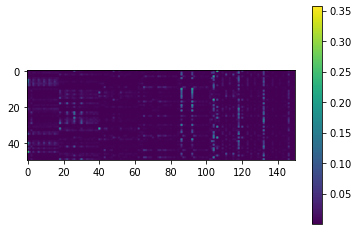

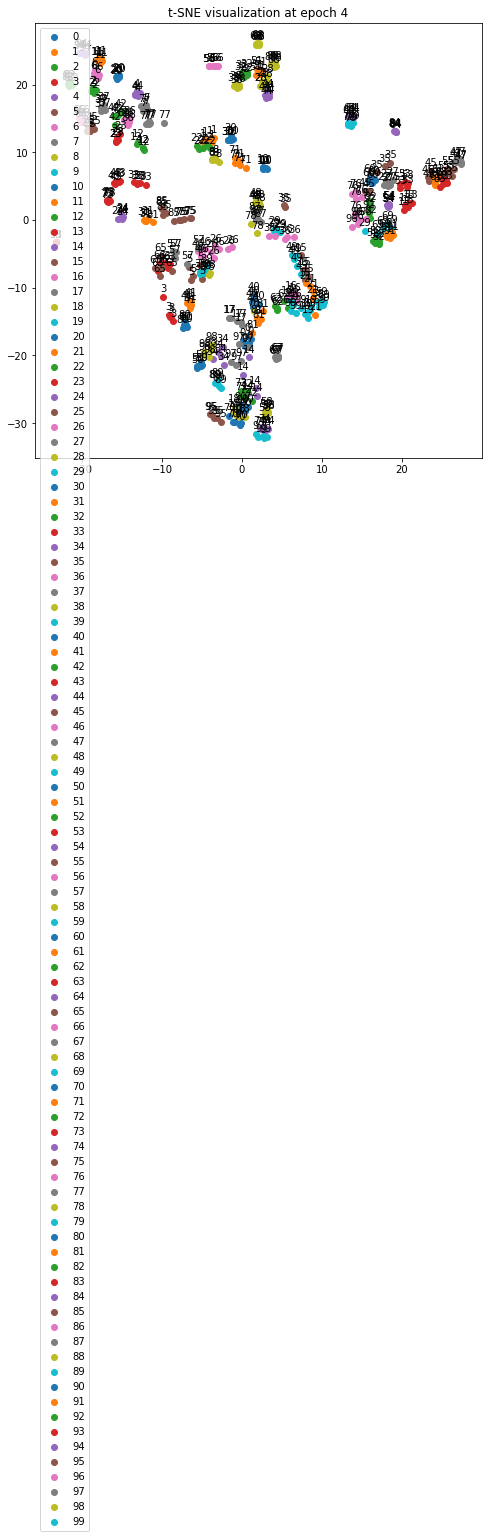

*****************************************Finished Epoch 81. Loss at 7.55911922454834.
*****************************************Finished Epoch 82. Loss at 7.614894866943359.
*****************************************Finished Epoch 83. Loss at 7.5759968757629395.
*****************************************Finished Epoch 84. Loss at 7.572013854980469.
*****************************************Finished Epoch 85. Loss at 7.557399272918701.
*****************************************Finished Epoch 86. Loss at 7.518264293670654.
*****************************************Finished Epoch 87. Loss at 7.564047336578369.
*****************************************Finished Epoch 88. Loss at 7.5446457862854.
*****************************************Finished Epoch 89. Loss at 7.544322490692139.
All Done!
--- 75.67408037185669 seconds ---


NameError: name 'model' is not defined

In [17]:
import time
start_time = time.time()
print('Starting Training:')
for i, epoch in enumerate(range(num_epochs)):
    for stats_batch, label_batch in statistics_dataloader:
        #grab texture batch and generate matching labels
        stats_batch = stats_batch.to(device)
        if stats_batch.shape[0] < batches:
            continue 
        #print(stats_batch.shape)
        stats_batch = torch.flatten(stats_batch, start_dim=0, end_dim=1)
        #print(stats_batch.shape) #torch.Size([batch_size, 5, 150])
        #print(label_batch) #label array of size batch_size containing image index
        texture_labels = torch.repeat_interleave(torch.arange(batches),num_crops).to(device)
        perm = torch.randperm(batches * num_crops)

        #current_batch_size = stats

        stats_batch = stats_batch[perm]
        texture_labels = texture_labels[perm]

        stats_vector = statnet_model.compressor(stats_batch)
        #print(stats_vector.shape)
        #loss definitions
        representation_loss = loss_func_contrastive(stats_vector, texture_labels)
        sparsity_loss = statnet_model.sparse_loss()
        loss = representation_loss + (sparsity_penalty * sparsity_loss) 
        #loss = triplet_loss(stats_vector, texture_labels, texture_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('*',end='')
        #training_loss.append(loss.item())      
        if(j%30==0):
            print(loss.item())
        if(j==100):
            break; 
        training_loss.append(loss.item())
    num_total_epochs = num_total_epochs + 1
    print(f'Finished Epoch {i}. Loss at {loss}.')
    #print('Initial Weights:', statnet_model._w)    
    if(i%10==0):
        compressor_mat = statnet_model.w.T.data.cpu().numpy()
        plt.imshow(compressor_mat)
        plt.colorbar() 
        plt.show()
        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        # Run t-SNE in PyTorch
        transformed = TorchTSNE(n_components=2).fit_transform(stats_vector_cpu)

        plt.figure(figsize=(8, 8))
        for label in np.unique(texture_labels_cpu):
            indices = np.where(texture_labels_cpu == label)
            x = transformed[indices, 0].squeeze()
            y = transformed[indices, 1].squeeze()
            plt.scatter(x, y, label=str(label))

            # Annotate each point with its label
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.annotate(str(label), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

        plt.legend()
        plt.title(f"t-SNE visualization at epoch {i}")
        plt.show()
print('All Done!')
print("--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'contrastive_model_HB.pth')


In [ ]:
from tsne_torch import TorchTSNE
import matplotlib.pyplot as plt
stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

# Run t-SNE in PyTorch
transformed = TorchTSNE(n_components=2).fit_transform(stats_vector_cpu)

plt.figure(figsize=(8, 8))
for label in np.unique(texture_labels_cpu):
    indices = np.where(texture_labels_cpu == label)
    x = transformed[indices, 0].squeeze()
    y = transformed[indices, 1].squeeze()
    plt.scatter(x, y, label=str(label))

    # Annotate each point with its label
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(str(label), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

plt.legend()
plt.title(f"t-SNE visualization at epoch {i}")
plt.show()

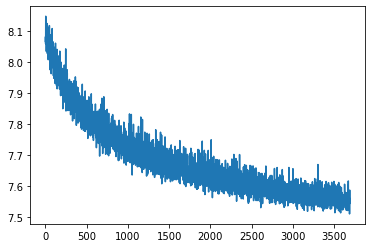

In [18]:
plt.plot(training_loss)

[[0.00093594 0.00092828 0.00262668 ... 0.00080357 0.00208613 0.00084653]
 [0.00648977 0.00840934 0.00169781 ... 0.00147186 0.00097481 0.00161968]
 [0.00147858 0.00099281 0.00387417 ... 0.00092991 0.0013402  0.00108254]
 ...
 [0.0010928  0.00135427 0.01533813 ... 0.00096362 0.00129702 0.00091363]
 [0.00091986 0.00125235 0.00089779 ... 0.00150958 0.00130633 0.00175044]
 [0.00177845 0.00136922 0.01721107 ... 0.00071645 0.00056272 0.00077291]]


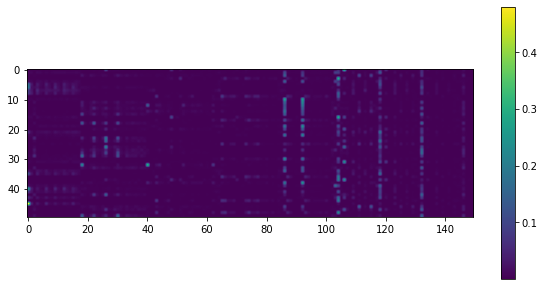

In [19]:
compressor_mat = statnet_model.w.T.data.cpu().numpy()
plt.figure(figsize=(10,5))
plt.imshow(compressor_mat)
plt.colorbar()
print(compressor_mat)

Most Important 25 Stats:
3.3347263 phase_correlation 1 er (0, 3)
3.1335025 edge_stop 4 2
3.1291096 phase_correlation 3 er (0, 3)
3.0532207 phase_correlation 2 er (0, 3)
3.0360055 edge_stop 4 0
1.6738569 phase_correlation 1 er (1, 3)
1.650627 mean
1.4082645 edge_mean 1 2
1.1351283 edge_mean 1 0
1.0083895 edge_mean 1 3
0.90162706 phase_correlation 4 er (0, 3)
0.85629624 edge_mean 1 1
0.6296613 phase_correlation (1, 2) er*di 1
0.6266618 edge_mean 2 0
0.616025 phase_correlation 1 er (0, 2)
0.55441254 phase_correlation (1, 2) er*di 3
0.5216911 edge_stop 3 0
0.47413298 phase_correlation 2 er (1, 3)
0.44815937 phase_correlation (1, 2) er*di 0
0.42730683 variance 3
0.4140118 variance 2
0.40750384 variance 5
0.40741217 edge_stop 2 0
0.406649 variance 1
0.40441987 variance 4


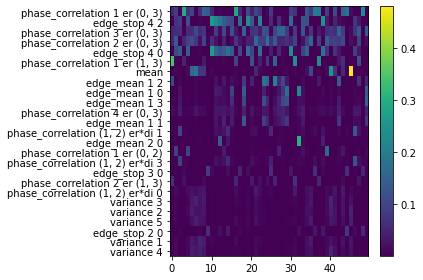

Least Important 25 Stats:
0.042168356 phase_correlation (1, 2) ei*di 2
0.04264939 phase_correlation (2, 3) ei*di 2
0.047778342 phase_correlation (3, 4) ei*di 2
0.05051122 phase_correlation (2, 3) ei*di 1
0.052198604 phase_correlation (1, 2) ei*di 1
0.052991327 phase_correlation (3, 4) ei*di 1
0.053562943 phase_correlation (2, 3) ei*di 0
0.054669674 edge_correlation (2, 3) 2
0.05518695 phase_correlation 3 er (1, 2)
0.05519199 phase_correlation (3, 4) ei*di 0
0.06006261 phase_correlation 3 er (2, 3)
0.062051952 phase_correlation (1, 2) ei*di 0
0.0628047 edge_variance 3 2
0.06399431 phase_correlation 4 er (1, 3)
0.06594939 phase_correlation 4 er (1, 2)
0.06762837 phase_correlation (1, 2) ei*di 3
0.06796402 edge_correlation 3 (1, 2)
0.06856365 phase_correlation 4 er (2, 3)
0.06931597 edge_stop 4 1
0.07291296 edge_correlation 3 (2, 3)
0.074084066 edge_correlation (3, 4) 2
0.075859666 edge_variance 2 2
0.08019249 phase_correlation 2 er (1, 2)
0.08099553 edge_correlation 4 (1, 2)
0.081222005 

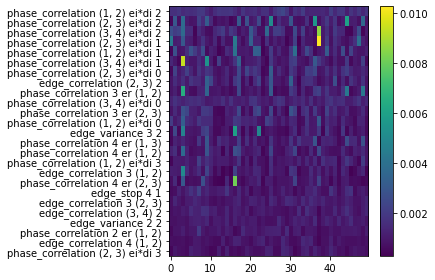

In [20]:
stat_sums = np.sum(np.abs(compressor_mat),axis=0) #how weighted is each of the 150 stats?
stat_index_array = np.argsort(stat_sums)[::-1] #get their importance order

ordered_stat_sums = stat_sums[stat_index_array]
ordered_stat_labels = np.array(stat_labels,dtype=object)[stat_index_array]
ordered_stats_labels_pretty = [' '.join([''.join(str(item)) for item in row if item not in ['',None]]) for row in ordered_stat_labels]

n=25
print(f'Most Important {n} Stats:')
for i in range(n):
    print(ordered_stat_sums[i],ordered_stats_labels_pretty[i])

#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)), labels=top_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    
    
#plot most important stats for contrastive learning
#plt.imshow(compressor_mat[:,stat_index_array[:n]].T)

print(f'Least Important {n} Stats:')
for i in range(1,n+1):
    print(ordered_stat_sums[-i],ordered_stats_labels_pretty[-i])
    
    
#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[-n:]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
bot_stats = ordered_stats_labels_pretty[-n:][::-1]
ax.set_yticks(np.arange(len(bot_stats)), labels=bot_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    

## Second part - Try contrastive learning with different compressor

### Also serves as a pretrained model for the next approach

In [64]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 100)
        self.layer2 = nn.Linear(100, 75)
        self.layer3 = nn.Linear(75, 50)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=75, bias=True)
  (layer3): Linear(in_features=75, out_features=50, bias=True)
)


In [14]:
### Try with a single layer for the original approach

class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 50)
        
    def forward(self, x):
        x = self.layer1(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=152, out_features=50, bias=True)
)


In [63]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 100)
        self.layer3 = nn.Linear(100, 50)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer3(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=50, bias=True)
)


In [15]:
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
model = EmbeddingModel()
model.to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_epochs = 100
num_total_epochs = 0
#[s for s in stat_labels] #print all stats with details
model.train() # Set model to training mode
optimizer.zero_grad()
model.zero_grad()

EmbeddingModel(
  (layer1): Linear(in_features=152, out_features=50, bias=True)
)


In [16]:
import time
start_time = time.time()
print('Starting Training:')
for i, epoch in enumerate(range(num_epochs)):
    for stats_batch, label_batch in statistics_dataloader:
        #grab texture batch and generate matching labels
        stats_batch = stats_batch.to(device)
        if stats_batch.shape[0] < batches:
            continue 
        #print(stats_batch.shape)
        stats_batch = torch.flatten(stats_batch, start_dim=0, end_dim=1)
        #print(stats_batch.shape) #torch.Size([batch_size, 5, 150])
        #print(label_batch) #label array of size batch_size containing image index
        texture_labels = torch.repeat_interleave(torch.arange(batches),num_crops).to(device)
        perm = torch.randperm(batches * num_crops)

        #current_batch_size = stats

        stats_batch = stats_batch[perm]
        texture_labels = texture_labels[perm]

        stats_vector = model(stats_batch)
        #print(stats_vector.shape)
        #loss definitions
        representation_loss = loss_func_contrastive(stats_vector, texture_labels)
        loss = representation_loss 
        #loss = triplet_loss(stats_vector, texture_labels, texture_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('*',end='')
        #training_loss.append(loss.item())      
        if(j%10==0):
            print(loss.item())
        if(j==1000):
            break; 
        training_loss.append(loss.item())
    num_total_epochs = num_total_epochs + 1
    print(f'Finished Epoch {i}. Loss at {loss}.')
    #print('Initial Weights:', statnet_model._w)    
    if(i==1100):
        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        # Run t-SNE in PyTorch
        transformed = TorchTSNE(n_components=2).fit_transform(stats_vector_cpu)

        plt.figure(figsize=(8, 8))
        for label in np.unique(texture_labels_cpu):
            indices = np.where(texture_labels_cpu == label)
            x = transformed[indices, 0].squeeze()
            y = transformed[indices, 1].squeeze()
            plt.scatter(x, y, label=str(label))

            # Annotate each point with its label
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.annotate(str(label), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

        plt.legend()
        plt.title(f"t-SNE visualization at epoch {i}")
        plt.show()
print('All Done!')
print("--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'contrastive_model_HB_KTH.pth')


Starting Training:
***********************************************Finished Epoch 0. Loss at 7.487674236297607.
***********************************************Finished Epoch 1. Loss at 7.473141193389893.
***********************************************Finished Epoch 2. Loss at 7.438352584838867.
***********************************************Finished Epoch 3. Loss at 7.396146774291992.
***********************************************Finished Epoch 4. Loss at 7.438957691192627.
***********************************************Finished Epoch 5. Loss at 7.421690940856934.
***********************************************Finished Epoch 6. Loss at 7.422635078430176.
***********************************************Finished Epoch 7. Loss at 7.43869686126709.
***********************************************Finished Epoch 8. Loss at 7.389273643493652.
***********************************************Finished Epoch 9. Loss at 7.384398460388184.
***********************************************Finished Epoch 

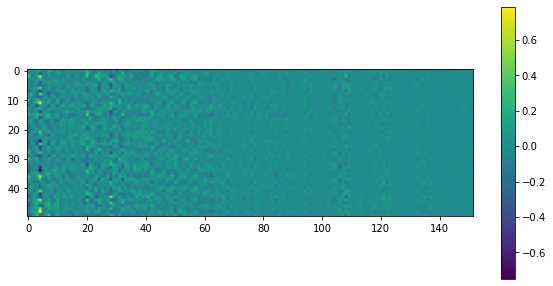

In [17]:
weights_layer1 = model.layer1.weight.data
# Converting the tensor to a NumPy array
compressor_mat = weights_layer1.cpu().numpy()
#print(compressor_mat.shape)

plt.figure(figsize=(10,5))
plt.imshow(compressor_mat)
plt.colorbar()
#print(compressor_mat)

Most Important 25 Stats:
16.404705 bandpass_variance 0
10.210677 edge_mean 1 2
8.509548 edge_mean 1 0
7.964609 mean
7.3394265 kurtosis
6.150571 kurtosis 1
5.779289 edge_mean 1 1
5.6531577 edge_mean 1 3
4.6804185 edge_mean 2 2
4.659087 edge_stop 1 2
4.6072273 edge_mean 2 0
4.57236 edge_stop 1 0
4.514362 kurtosis 2
4.312343 edge_variance 1 2
3.8408554 edge_correlation 1 (1, 3)
3.7583864 edge_variance 1 0
3.7337646 phase_correlation 1 er (1, 3)
3.698607 edge_correlation 2 (1, 3)
3.631504 skew 1
3.6124942 edge_correlation (1, 2) 3
3.5542173 edge_correlation (1, 2) 1
3.520757 skew 4
3.4596374 skew 3
3.4374585 edge_mean 2 1
3.3599284 kurtosis 5


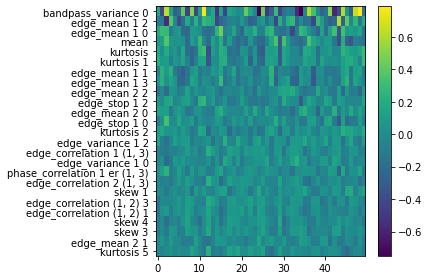

Least Important 25 Stats:
0.02150962 phase_correlation (3, 4) ei*di 3
0.029091734 phase_correlation (2, 3) ei*di 2
0.04605402 phase_correlation (2, 3) ei*di 1
0.046703737 phase_correlation (1, 2) ei*di 3
0.052631855 edge_stop 4 3
0.05363801 phase_correlation (1, 2) ei*di 0
0.054928377 phase_correlation (3, 4) ei*di 1
0.05617413 phase_correlation (2, 3) ei*di 0
0.056407675 edge_stop 4 1
0.056591485 phase_correlation (1, 2) ei*di 1
0.062648095 phase_correlation (2, 3) ei*di 3
0.06325549 phase_correlation (1, 2) ei*di 2
0.06536476 phase_correlation (3, 4) ei*di 0
0.06778904 phase_correlation (3, 4) ei*di 2
0.08487385 phase_correlation (3, 4) er*di 2
0.087556966 phase_correlation (3, 4) er*di 0
0.088515304 phase_correlation 4 er (1, 3)
0.09190635 phase_correlation 4 er (0, 2)
0.112485506 phase_correlation (3, 4) er*di 3
0.1683985 phase_correlation (3, 4) er*di 1
0.22389983 phase_correlation (2, 3) er*di 2
0.24042025 phase_correlation 3 er (0, 2)
0.2700487 phase_correlation (2, 3) er*di 0
0

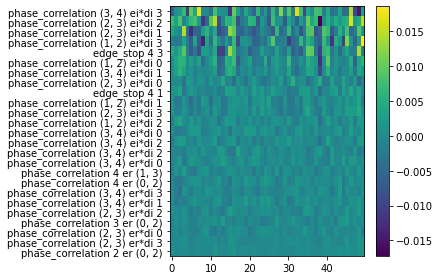

In [20]:
stat_sums = np.sum(np.abs(compressor_mat),axis=0) #how weighted is each of the 150 stats?
stat_index_array = np.argsort(stat_sums)[::-1] #get their importance order

ordered_stat_sums = stat_sums[stat_index_array]
ordered_stat_labels = np.array(stat_labels,dtype=object)[stat_index_array]
ordered_stats_labels_pretty = [' '.join([''.join(str(item)) for item in row if item not in ['',None]]) for row in ordered_stat_labels]

n=25
print(f'Most Important {n} Stats:')
for i in range(n):
    print(ordered_stat_sums[i],ordered_stats_labels_pretty[i])

#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)), labels=top_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    
    
#plot most important stats for contrastive learning
#plt.imshow(compressor_mat[:,stat_index_array[:n]].T)

print(f'Least Important {n} Stats:')
for i in range(1,n+1):
    print(ordered_stat_sums[-i],ordered_stats_labels_pretty[-i])
    
    
#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[-n:]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
bot_stats = ordered_stats_labels_pretty[-n:][::-1]
ax.set_yticks(np.arange(len(bot_stats)), labels=bot_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    

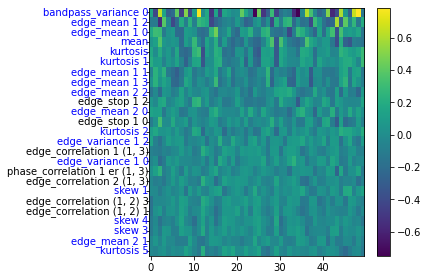

In [21]:

fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)

top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)))  # Only set the ticks, not the labels
ax.set_yticklabels([])  # Suppress the default ytick labels

# Place the ytick labels using ax.text and color those containing "kurtosis" or "mean"
for i, label in enumerate(top_stats):
    color = 'blue' if 'variance' in label or 'mean' in label or 'kurtosis' in label or 'skew' in label else 'black'
    ax.text(-0.5, i, label, va='center', ha='right', color=color)

plt.tight_layout()
plt.show()

In [22]:
variance = [i for i, label in enumerate(ostat_labels) if 'variance' in label]
mean = [i for i, label in enumerate(ostat_labels) if 'mean' in label]
skew = [i for i, label in enumerate(ostat_labels) if 'skew' in label]
kurtosis = [i for i, label in enumerate(ostat_labels) if 'kurtosis' in label]

heegerbergen_indices = variance + mean + skew + kurtosis

all_indices = set(range(len(ostat_labels)))
remaining_indices = sorted(list(all_indices - set(heegerbergen_indices)))
#print(remaining_indices)
#print(len(combined_indices))
#print(stat_index_array)
# Convert the numpy array to a list for easier indexing
stat_index_list = list(stat_index_array)

# Compute the ranks/positions
ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Computing the median rank
ranks_sorted = sorted(ranks)
length = len(ranks_sorted)

if length % 2 == 1:  # odd number of ranks
    median_rank = ranks_sorted[length // 2]
else:  # even number of ranks
    median_rank = (ranks_sorted[length // 2 - 1] + ranks_sorted[length // 2]) / 2

print(median_rank)  # This should print 4.0

# Checking the intersection of the first 75 elements with heegerbergen_indices
count = sum(1 for index in stat_index_array[:15] if index in heegerbergen_indices)

print(count)

43.0
8


In [22]:
# Compute the ranks
stat_index_list = list(stat_index_array)

ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Compute the mean rank
mean_rank = sum(ranks) / len(ranks) if ranks else None

print(mean_rank)  # This should print 4.0



52.36


In [23]:
variance = [i for i, label in enumerate(ostat_labels) if 'edge_variance' in label]
mean = [i for i, label in enumerate(ostat_labels) if 'edge_mean' in label]
skew = [i for i, label in enumerate(ostat_labels) if 'skew' in label]
kurtosis = [i for i, label in enumerate(ostat_labels) if 'kurtosis' in label]
phase = [i for i, label in enumerate(ostat_labels) if 'phase' in label]
correlation = [i for i, label in enumerate(ostat_labels) if 'correlation' in label]
stop = [i for i, label in enumerate(ostat_labels) if 'stop' in label]


all_indices = set(range(len(ostat_labels)))
remaining_indices = variance + mean + phase + correlation + stop

all_indices = set(range(len(ostat_labels)))
heegerbergen_indices = sorted(list(all_indices - set(remaining_indices)))
print(heegerbergen_indices)
#print(len(combined_indices))
#print(stat_index_array)
# Convert the numpy array to a list for easier indexing
stat_index_list = list(stat_index_array)

# Compute the ranks/positions
ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Computing the median rank
ranks_sorted = sorted(ranks)
length = len(ranks_sorted)

if length % 2 == 1:  # odd number of ranks
    median_rank = ranks_sorted[length // 2]
else:  # even number of ranks
    median_rank = (ranks_sorted[length // 2 - 1] + ranks_sorted[length // 2]) / 2

print(median_rank)  # This should print 4.0

# Checking the intersection of the first 75 elements with heegerbergen_indices
count = sum(1 for index in stat_index_array[:25] if index in heegerbergen_indices)

print(count)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
28.5
8
